<a href="https://colab.research.google.com/github/bhaweshiitk/20.C51_project/blob/main/20_C51_Graduate_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib
import torch
from torch import nn
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
! pip install Bio
!pip install umap-learn
from Bio import SeqIO
import umap

     |████████████████████████████████| 269 kB 6.1 MB/s 
     |████████████████████████████████| 2.3 MB 16.0 MB/s 
     |████████████████████████████████| 88 kB 4.4 MB/s 
     |████████████████████████████████| 1.1 MB 41.6 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=53513891b539d91301a459b2e836215ef3242c321869224d701a59b6cc888b41
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=7efe918e225645d63abf1ba3dd004a02340dd32d0702bd5ae85fe7655ce1792e
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent


In [ ]:
# RNN, Hybrid RNN-CNN
# Linear regression, MLP, Random Forest
# Hyperparam tuning 
# Distance between train and test set

In [2]:
# Import data
! wget https://raw.githubusercontent.com/bhaweshiitk/3.C51_project/main/megares_modified_annotations_v2.00.csv
! wget https://raw.githubusercontent.com/bhaweshiitk/3.C51_project/main/megares_modified_database_v2.00.fasta

--2022-05-02 14:09:28--  https://raw.githubusercontent.com/bhaweshiitk/3.C51_project/main/megares_modified_annotations_v2.00.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 948917 (927K) [text/plain]
Saving to: ‘megares_modified_annotations_v2.00.csv’

megares_modified_an 100%[===================>] 926.68K  --.-KB/s    in 0.02s   

2022-05-02 14:09:29 (36.6 MB/s) - ‘megares_modified_annotations_v2.00.csv’ saved [948917/948917]

--2022-05-02 14:09:29--  https://raw.githubusercontent.com/bhaweshiitk/3.C51_project/main/megares_modified_database_v2.00.fasta
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.13

In [3]:
# Process data
train_annotations = pd.read_csv("./megares_modified_annotations_v2.00.csv")
train_annotations.shape

(7868, 5)

In [4]:
train_annotations.head()

,header,type,class,mechanism,group
0,MEG_1|Drugs|Aminoglycosides|Aminoglycoside-res...,Drugs,Aminoglycosides,Aminoglycoside-resistant 16S ribosomal subunit...,A16S
1,MEG_2|Drugs|Aminoglycosides|Aminoglycoside-res...,Drugs,Aminoglycosides,Aminoglycoside-resistant 16S ribosomal subunit...,A16S
2,MEG_3|Drugs|Aminoglycosides|Aminoglycoside-res...,Drugs,Aminoglycosides,Aminoglycoside-resistant 16S ribosomal subunit...,A16S
3,MEG_4|Drugs|Aminoglycosides|Aminoglycoside-res...,Drugs,Aminoglycosides,Aminoglycoside-resistant 16S ribosomal subunit...,A16S
4,MEG_5|Drugs|Aminoglycosides|Aminoglycoside-res...,Drugs,Aminoglycosides,Aminoglycoside-resistant 16S ribosomal subunit...,A16S


In [5]:
train_annotations['Seq_name'] = train_annotations['header'].str.split('|').str[0:2].apply('|'.join)
train_annotations['mechanism'] = train_annotations['header'].str.split('|').str[3]

In [6]:
fasta_sequences = SeqIO.parse(open("./megares_modified_database_v2.00.fasta"),'fasta')
sequence_dict = {}
for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)
    name = "|".join((name.split("|", 2))[0:2])
    sequence_dict[name] = sequence
sequence_df = pd.DataFrame(sequence_dict.items(), columns=['Seq_name', 'Sequence'])
sequence_df.shape

(7868, 2)

In [7]:
sequence_df.head()

,Seq_name,Sequence
0,MEG_1|Drugs,AGAATTTGATCTTGGTTCAGATTGAACGCTGGCGGCGTGGATGAGG...
1,MEG_2|Drugs,AGGTAAGGAGGTGATCCAACCGCAGGTTCCCCTACGGTTACCTTGT...
2,MEG_3|Drugs,TTTTGTTTGGAGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGC...
3,MEG_4|Drugs,AGAGATTGAACATAAGAGTTTGATCCTGGCTCAGATTGAACGCTGG...
4,MEG_5|Drugs,AGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCGTGCTTAACA...


In [8]:
df = pd.merge(train_annotations[['Seq_name', 'type', 'class','mechanism','group']], 
              sequence_df, how = "inner", on = ["Seq_name"])
df.shape

(7868, 6)

In [9]:
df.head()

,Seq_name,type,class,mechanism,group,Sequence
0,MEG_1|Drugs,Drugs,Aminoglycosides,Aminoglycoside-resistant_16S_ribosomal_subunit...,A16S,AGAATTTGATCTTGGTTCAGATTGAACGCTGGCGGCGTGGATGAGG...
1,MEG_2|Drugs,Drugs,Aminoglycosides,Aminoglycoside-resistant_16S_ribosomal_subunit...,A16S,AGGTAAGGAGGTGATCCAACCGCAGGTTCCCCTACGGTTACCTTGT...
2,MEG_3|Drugs,Drugs,Aminoglycosides,Aminoglycoside-resistant_16S_ribosomal_subunit...,A16S,TTTTGTTTGGAGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGC...
3,MEG_4|Drugs,Drugs,Aminoglycosides,Aminoglycoside-resistant_16S_ribosomal_subunit...,A16S,AGAGATTGAACATAAGAGTTTGATCCTGGCTCAGATTGAACGCTGG...
4,MEG_5|Drugs,Drugs,Aminoglycosides,Aminoglycoside-resistant_16S_ribosomal_subunit...,A16S,AGAGTTTGATCCTGGCTCAGGACGAACGCTGGCGGCGTGCTTAACA...


In [10]:
df["class"].value_counts()

betalactams                                        3911
Aminoglycosides                                     773
Drug and biocide resistance                         363
Glycopeptides                                       299
Fluoroquinolones                                    296
Tetracyclines                                       294
MLS                                                 270
Multi-metal resistance                              226
Phenicol                                            145
Trimethoprim                                        135
Copper resistance                                   117
Multi-drug resistance                               113
Sulfonamides                                        103
Multi-biocide resistance                             98
Lipopeptides                                         95
Rifampin                                             70
Fosfomycin                                           62
Mercury resistance                              

In [11]:
df["mechanism"].value_counts()

Class_A_betalactamases                 1580
Class_C_betalactamases                  950
Class_D_betalactamases                  900
Class_B_betalactamases                  410
Aminoglycoside_N-acetyltransferases     359
                                       ... 
Tetracenomycin_MFS_efflux_pump            1
Tunicamycin_resistance_protein            1
Chromate_ABC_efflux_pump                  1
Biguanide_cation_efflux                   1
Sulfonamide_monooxygenase                 1
Name: mechanism, Length: 219, dtype: int64

In [12]:
label_1 = ['Aminoglycosides', 'betalactams', 'Glycopeptides', 'Tetracyclines', 'MLS', 'Fluoroquinolones']
label_2 = ['Class_A_betalactamases', 'Class_B_betalactamases', 'Class_c_betalactamases', 'Class_D_betalactamases']

In [13]:
df['labels'] = df["class"]
df.loc[~df['labels'].isin(label_1),'labels'] = "other"

In [14]:
df.labels.value_counts()

betalactams         3911
other               2025
Aminoglycosides      773
Glycopeptides        299
Fluoroquinolones     296
Tetracyclines        294
MLS                  270
Name: labels, dtype: int64

In [15]:
X = df.Sequence.values
y = df.labels.values
print(X.shape, y.shape)
index_to_remove = []
for (i, seq) in enumerate(X):
  if set(seq.upper())!={"A", "T", "C", "G"}:
    index_to_remove.append(i)
index_to_remove
X = np.delete(X, index_to_remove, axis=0)
y = np.delete(y, index_to_remove, axis=0)
print(X.shape, y.shape)


(7868,) (7868,)
(7819,) (7819,)


In [16]:
code = {'A': 1, 'C': 2, 'G': 3, 'T': 4}
label_code_1 = {"betalactams":0, "Aminoglycosides":1, "Glycopeptides":2, "Fluoroquinolones":3, "Tetracyclines":4, "MLS":5,
              "other":6}
import torch.nn.functional as F

def encode(seq, label, labels_dict):
  label_int = labels_dict[label]
  enc_seq = [code[x] for x in seq.upper()]
  return [torch.LongTensor(enc_seq[0:2000]), torch.LongTensor([label_int]), len(enc_seq)]

class SequenceDataset(Dataset):
    def __init__(self, X, y, labels_dict):
        
        self.X = X 
        self.y = y 
        self.labels_dict =labels_dict
        self.len=len(self.X)      

    def __getitem__(self, index):
        # your implementation here: 
        X_elem, y_elem, length_seq = encode(self.X[index], self.y[index], labels_dict=self.labels_dict)
        return F.pad(X_elem, pad=(0, 2000 - len(X_elem))), y_elem

    def __len__(self):
        return self.len
    




In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1) 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1) 

In [18]:
train_data = SequenceDataset(X_train, y_train, labels_dict=label_code_1)
val_data = SequenceDataset(X_val, y_val, labels_dict=label_code_1)
test_data = SequenceDataset(X_test, y_test, labels_dict=label_code_1)

batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)# fill in code here
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)# fill in code here
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)# fill in code here

In [19]:
class cnn1d(nn.Module):
    def __init__(self, label_count = 7):
        super(cnn1d, self).__init__()
        self.embedding = nn.Embedding(5, 8)
        self.conv1 = nn.Conv1d(8, 64, kernel_size = 3, padding='same')
        self.maxpool1 = nn.MaxPool1d(kernel_size=5)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding="same")
        self.maxpool2 = nn.MaxPool1d(kernel_size=5)
        self.conv3 = nn.Conv1d(64, 64, kernel_size=3, padding="same")
        self.maxpool3 = nn.MaxPool1d(kernel_size=5)
        self.dense = nn.Sequential(nn.Linear(1024, 256), 
                             nn.ReLU(), nn.Linear(256, 64),
                             nn.ReLU(), nn.Linear(64, label_count))

    def forward(self, x):
        """Extract first fully connected feature vector"""
        # Apply convolutions
        x = self.embedding(x)
        # print(x.shape)
        # Apply pooling
        x = self.conv1(x.permute(0, 2, 1))
        # print(x.shape)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.maxpool3(x)
        x = torch.flatten(x, 1)
        x = self.dense(x)
        # print(x.shape)
        # Flatten and convert to vectors
        # x = torch.flatten(x, 1)
        # x = self.fc1(x)
        # x = self.classifier(x)
        return x

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [21]:
model = cnn1d()
model = model.to(device)
# for data in train_loader:
#   model(data[0])


In [22]:
optimizer = torch.optim.Adam(list(model.parameters()), lr=1e-3) 

In [23]:
def train(model, dataloader, optimizer, device):
    
    '''
    A function to train on the entire dataset for one epoch.
    
    Args: 
        model (torch.nn.Module): Your sequence classifier 
        dataloader (torch.utils.data.Dataloader): DataLoader object for the train data
        optimizer (torch.optim.Optimizer): Optimizer object to interface gradient calculation and optimization 
        device (str): Your device
        
    Returns: 
        float: loss averaged over all the batches 
    
    '''

    batch_loss = []
    model.train() # Set model to training mode 
    train_loss = 0 
    count = 0
    for batch in dataloader:    
        seq, label = batch
        seq = seq.to(device)
        label = label.to(device)
        
        # train your model on each batch here 
        y_pred = model(seq)
        loss = nn.functional.cross_entropy(y_pred, label.squeeze())# fill in loss here
        train_loss += loss*len(label)
        count += len(label)
        batch_loss.append(loss.item())
        
        # run backpropagation given the loss you defined
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss = train_loss/count
    return np.array(batch_loss).mean(), train_loss


def validate(model, dataloader, device):
    
    '''
    A function to validate on the validation dataset for one epoch.
    
    Args: 
        model (torch.nn.Module): Your sequence classifier 
        dataloader (torch.utils.data.Dataloader): DataLoader object for the validation data
        device (str): Your device
        
    Returns: 
        float: loss averaged over all the batches 
    
    '''
    
    val_loss = []
    model.eval() # Set model to evaluation mode 
    with torch.no_grad():    
        for batch in dataloader:
            seq, label = batch
            seq = seq.to(device)
            label = label.to(device)
            y_pred = model(seq)
            loss = nn.functional.cross_entropy(y_pred, label.squeeze())# fill in loss here
            val_loss.append(loss.item())
            # validate your model on each batch here 
            
    return np.array(val_loss).mean()   

In [24]:
print("epoch", "train loss", "validation loss")

val_loss_curve = []
train_loss_curve = []

for epoch in range(6):
    
    # Compute train your model on training data
    epoch_loss, train_loss = train(model, train_dataloader, optimizer,  device=0)
    
    # Validate your on validation data 
    val_loss = validate(model, val_dataloader, device=0) 
    
    # Record train and loss performance 
    train_loss_curve.append(epoch_loss)
    val_loss_curve.append(val_loss)
    
    # The learning rate scheduler records the validation loss 
    # scheduler.step(val_loss)
    
    print(epoch, epoch_loss, val_loss)

epoch train loss validation loss
0 0.9726727325586403 0.7051033046510484
1 0.5822791577135242 0.47052836749288773
2 0.40291342396968566 0.42253055920203525
3 0.2939989653960714 0.38989051514201695
4 0.22587774782998007 0.4030098227990998
5 0.15316077573634918 0.3598250072035525


In [25]:
pred_labels = []
true_labels = []
test_loss = 0
with torch.no_grad():
  model.eval()
  for batch in test_dataloader:
    seq, label = batch
    seq = seq.to(device)
    label = label.to(device)
    logits = model(seq)
    test_loss += nn.functional.cross_entropy(logits, label.squeeze())*len(label)
    preds = logits.max(1).indices
    true_labels.extend(list(label.squeeze().detach().cpu().numpy()))
    pred_labels.extend(list(preds.squeeze().detach().cpu().numpy()))
test_loss = test_loss/len(test_data)

In [26]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(true_labels, pred_labels)
cmat

array([[744,   0,   0,   1,   0,   1,  20],
       [  0, 124,   0,   0,   1,   2,  23],
       [  1,   0,  52,   0,   0,   0,   9],
       [  0,   0,   0,  46,   0,   0,   7],
       [  0,   1,   0,   0,  45,   0,   8],
       [  2,   3,   0,   0,   0,  32,  12],
       [ 15,  14,   5,   0,   5,   7, 384]])

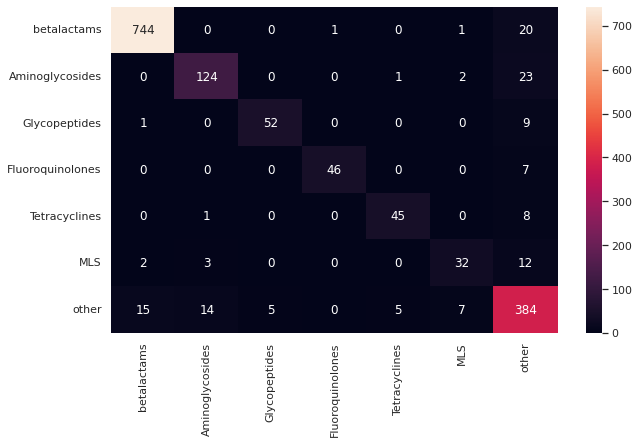

In [27]:
import seaborn as sns
sns.set(rc = {'figure.figsize':(10,6)})

fig, ax = plt.subplots()
sns.heatmap(cmat, annot=cmat, fmt="",  ax=ax, yticklabels=(label_code_1.keys()),
            xticklabels=label_code_1.keys())
plt.show()

In [28]:
def get_avg_length_of_seq(df):
  dict_stats = {}
  for classes in label_1:
    df_temp = df[(df["class"]==classes)&(df['Sequence'].str.len()<=2000)]
    df_temp["length"] = df_temp['Sequence'].str.len()
    dict_stats[classes] = (df_temp["length"].mean(), df_temp["length"].std(), df_temp["length"].max(), df_temp["length"].min())
  return dict_stats

In [29]:
dict_stats = get_avg_length_of_seq(df)
dict_stats

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


{'Aminoglycosides': (696.3031088082902, 212.82609243082857, 1551, 375),
 'Fluoroquinolones': (736.4894736842106, 287.85923476944305, 1998, 198),
 'Glycopeptides': (923.1278195488721, 305.4917573179186, 1971, 228),
 'MLS': (914.924, 269.2891994040286, 1710, 417),
 'Tetracyclines': (1494.5358361774745, 430.184887273795, 1992, 312),
 'betalactams': (934.7947924722866, 169.142251527775, 1998, 211)}

In [30]:
model_cut = torch.nn.Sequential(*(list(model.children())[:-1]), model.dense[:-2])
model_cut

Sequential(
  (0): Embedding(5, 8)
  (1): Conv1d(8, 64, kernel_size=(3,), stride=(1,), padding=same)
  (2): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same)
  (4): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (5): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same)
  (6): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (7): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
  )
)

In [31]:
# model_cut = nn.Sequential(*[model.children for i in range(1)])
# model_cut
embedding_list = []
label_list = []
model_cut.eval() # Set model to evaluation mode 
with torch.no_grad():    
    for batch in train_dataloader:
        seq, label = batch
        seq = seq.to(device)
        label = label.to(device)
        seq = model_cut[0](seq)

        # print(x.shape)
        # Apply pooling
        seq = model_cut[1](seq.permute(0, 2, 1))
        seq = model_cut[2:7](seq)
        seq = torch.flatten(seq, 1)
        y_pred = model_cut[7](seq)
        label_list.extend(list(label.squeeze().detach().cpu().numpy()))
        embedding_list.extend(list(y_pred.detach().cpu().numpy()))
        
            # validate your model on each batch here

In [32]:
embedding_list = np.array(embedding_list)
label_list = np.array(label_list)
embedding_list.shape, label_list.shape

((5066, 64), (5066,))

In [33]:
label_value = [list(label_code_1.keys())[list(label_code_1.values()).index(p)] for p in label_list]

In [34]:
len(label_list), len(label_value)

(5066, 5066)

In [35]:
df_embedding = pd.DataFrame(data = (embedding_list))
# df_embedding["label"] = np.array(label_value)
df_embedding.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,4.477238,-4.411314,2.558364,-2.493635,-1.128750,-5.487415,-4.497297,1.784900,-1.423580,0.475206,...,-5.602770,-3.591656,5.682186,2.527809,-1.724958,-5.215575,-2.848783,-5.074184,-4.839429,5.325947
1,10.811935,-9.820178,6.837152,-2.439466,-5.750671,-7.469245,-6.198266,-3.440151,-1.050638,-0.550265,...,-3.381588,-6.561138,5.092988,8.087996,-3.222291,-2.519456,-3.488373,-2.424224,-4.140232,-1.994226
2,6.292338,-6.079090,3.664793,0.145721,-1.639862,-6.066694,-4.509429,2.937315,0.864065,1.870628,...,-1.955793,-4.925997,4.666681,1.440320,2.412336,-1.600139,-3.215956,0.240663,-4.113581,5.636428
3,7.628315,-11.355264,6.573164,9.121807,-9.705730,-9.135552,-7.881690,0.949616,7.832936,-1.025989,...,-3.898307,-7.095425,8.777316,11.832479,-0.931471,0.179735,-7.392890,-4.113302,-7.680186,-0.703291
4,1.204077,-2.653465,-0.220260,-5.405383,-1.549548,-5.422018,-2.670910,1.747695,5.479167,0.159730,...,-4.871344,-4.766559,1.341357,4.998228,-4.709524,-2.133127,-0.628323,-3.240006,-4.448056,2.665283


In [36]:
fit = umap.UMAP(n_neighbors=30, min_dist = 0.1)
# Use default parameters?

In [37]:
reduced_embedding = fit.fit_transform(df_embedding)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [38]:
reduced_embedding = pd.DataFrame(reduced_embedding, columns=['dim1', 'dim2'])
reduced_embedding["label"] = np.array(label_value)

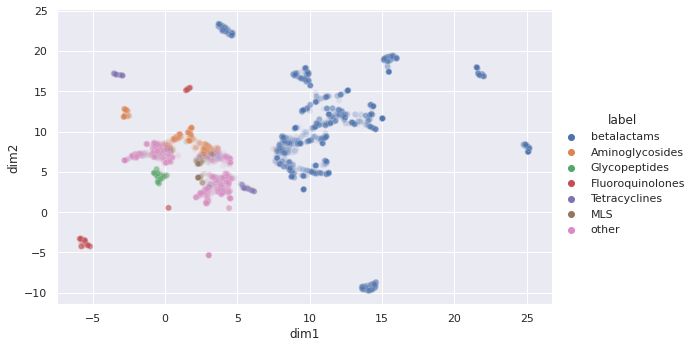

In [39]:
sns.relplot(data=reduced_embedding, x="dim1", y='dim2',
                hue='label', hue_order=label_code_1.keys(), aspect=1.61, alpha = 0.1)
plt.show()

In [40]:
df["labels_2"] = df["labels"]
df.loc[(df['mechanism'] == "Class_A_betalactamases"),'labels_2'] = "Class_A_betalactamases"
df.loc[(df['mechanism'] == "Class_B_betalactamases"),'labels_2'] = "Class_B_betalactamases"
df.loc[(df['mechanism'] == "Class_C_betalactamases"),'labels_2'] = "Class_C_betalactamases"
df.loc[(df['mechanism'] == "Class_D_betalactamases"),'labels_2'] = "Class_D_betalactamases"

In [41]:
df.labels_2.value_counts()

other                     2025
Class_A_betalactamases    1580
Class_C_betalactamases     950
Class_D_betalactamases     900
Aminoglycosides            773
Class_B_betalactamases     410
Glycopeptides              299
Fluoroquinolones           296
Tetracyclines              294
MLS                        270
betalactams                 71
Name: labels_2, dtype: int64

In [42]:
label_code_2 = {"betalactams":0, "Aminoglycosides":1, "Glycopeptides":2, "Fluoroquinolones":3, "Tetracyclines":4, "MLS":5,
              "other":6, "Class_A_betalactamases":7, "Class_B_betalactamases":8, "Class_C_betalactamases":9,
              "Class_D_betalactamases":10}

In [43]:
X = df.Sequence.values
y = df.labels_2.values
print(X.shape, y.shape)
index_to_remove = []
for (i, seq) in enumerate(X):
  if set(seq.upper())!={"A", "T", "C", "G"}:
    index_to_remove.append(i)
index_to_remove
X = np.delete(X, index_to_remove, axis=0)
y = np.delete(y, index_to_remove, axis=0)
print(X.shape, y.shape)

(7868,) (7868,)
(7819,) (7819,)


In [44]:
from pandas.core.algorithms import unique
unique(y)

array(['Aminoglycosides', 'other', 'Class_C_betalactamases',
       'Class_A_betalactamases', 'Class_B_betalactamases', 'betalactams',
       'Class_D_betalactamases', 'Glycopeptides', 'MLS',
       'Fluoroquinolones', 'Tetracyclines'], dtype=object)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1) 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1) 

In [46]:
train_data = SequenceDataset(X_train, y_train, labels_dict = label_code_2)
val_data = SequenceDataset(X_val, y_val, labels_dict = label_code_2)
test_data = SequenceDataset(X_test, y_test, labels_dict = label_code_2)

batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)# fill in code here
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)# fill in code here
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)# fill in code here

In [47]:
model = cnn1d(label_count=len(label_code_2))
model = model.to(device)

In [48]:
model

cnn1d(
  (embedding): Embedding(5, 8)
  (conv1): Conv1d(8, 64, kernel_size=(3,), stride=(1,), padding=same)
  (maxpool1): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same)
  (maxpool2): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same)
  (maxpool3): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (dense): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=11, bias=True)
  )
)

In [49]:
optimizer = torch.optim.Adam(list(model.parameters()), lr=1e-3) 

In [50]:
print("epoch", "train loss", "validation loss")

val_loss_curve = []
train_loss_curve = []

for epoch in range(7):
    
    # Compute train your model on training data
    epoch_loss, train_loss = train(model, train_dataloader, optimizer,  device=0)
    
    # Validate your on validation data 
    val_loss = validate(model, val_dataloader, device=0) 
    
    # Record train and loss performance 
    train_loss_curve.append(epoch_loss)
    val_loss_curve.append(val_loss)
    
    # The learning rate scheduler records the validation loss 
    # scheduler.step(val_loss)
    
    print(epoch, epoch_loss, val_loss)

epoch train loss validation loss
0 1.2749725943841275 0.9217702084117465
1 0.7945606612934256 0.572700591550933
2 0.5347316594993543 0.43463123755322564
3 0.37553407771969743 0.3457268203298251
4 0.2535891679098021 0.3192956989838017
5 0.16912668518745486 0.3376757577061653
6 0.11185218074575723 0.3808147468500667


In [51]:
pred_labels = []
true_labels = []
test_loss = 0
with torch.no_grad():
  model.eval()
  for batch in test_dataloader:
    seq, label = batch
    seq = seq.to(device)
    label = label.to(device)
    logits = model(seq)
    test_loss += nn.functional.cross_entropy(logits, label.squeeze())*len(label)
    preds = logits.max(1).indices
    true_labels.extend(list(label.squeeze().detach().cpu().numpy()))
    pred_labels.extend(list(preds.squeeze().detach().cpu().numpy()))
test_loss = test_loss/len(test_data)

In [52]:
cmat = confusion_matrix(true_labels, pred_labels)
cmat

array([[  7,   0,   0,   0,   0,   1,   6,   0,   0,   1,   0],
       [  0, 118,   0,   0,   0,  16,  14,   0,   0,   0,   0],
       [  0,   0,  55,   1,   0,   2,   9,   0,   0,   0,   0],
       [  0,   1,   0,  58,   0,   0,   7,   0,   0,   0,   0],
       [  0,   1,   0,   1,  38,   1,   7,   0,   0,   0,   0],
       [  0,   3,   0,   0,   0,  44,   5,   0,   1,   0,   0],
       [  0,   8,   6,   4,   3,  22, 346,   4,   1,   3,   0],
       [  0,   0,   0,   0,   0,   4,   2, 322,   1,   0,   0],
       [  0,   0,   0,   0,   0,   2,   3,   0,  74,   0,   0],
       [  0,   0,   0,   0,   0,   0,   2,   0,   0, 173,   0],
       [  0,   3,   1,   0,   0,   7,   1,   1,   1,   0, 173]])

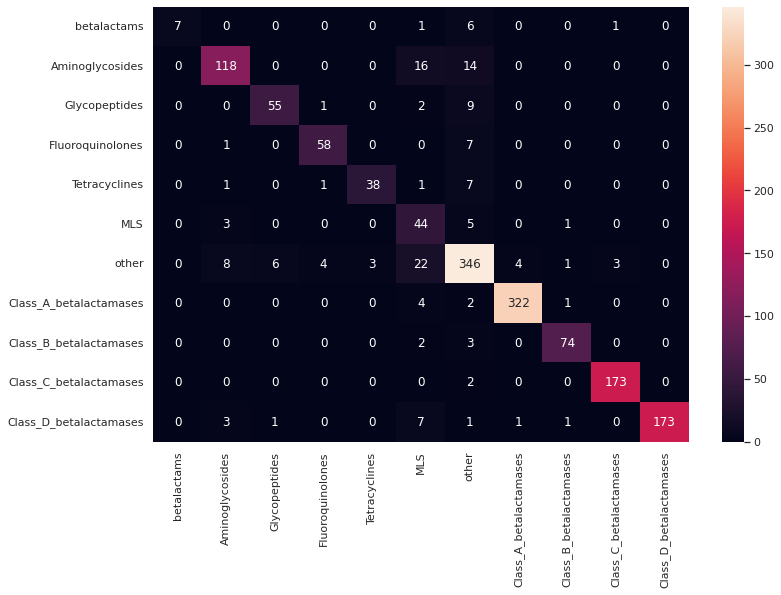

In [53]:
sns.set(rc = {'figure.figsize':(12,8)})
fig, ax = plt.subplots()
sns.heatmap(cmat, annot=cmat, fmt="",  ax=ax, yticklabels=(label_code_2.keys()),
            xticklabels=label_code_2.keys())
plt.show()

In [ ]:
model_cut = torch.nn.Sequential(*(list(model.children())[:-1]), model.dense[:-2])
model_cut

Sequential(
  (0): Embedding(5, 8)
  (1): Conv1d(8, 64, kernel_size=(3,), stride=(1,), padding=same)
  (2): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same)
  (4): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (5): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same)
  (6): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (7): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
  )
)

In [ ]:
# model_cut = nn.Sequential(*[model.children for i in range(1)])
# model_cut
embedding_list = []
label_list = []
model_cut.eval() # Set model to evaluation mode 
with torch.no_grad():    
    for batch in train_dataloader:
        seq, label = batch
        seq = seq.to(device)
        label = label.to(device)
        seq = model_cut[0](seq)

        # print(x.shape)
        # Apply pooling
        seq = model_cut[1](seq.permute(0, 2, 1))
        seq = model_cut[2:7](seq)
        seq = torch.flatten(seq, 1)
        y_pred = model_cut[7](seq)
        label_list.extend(list(label.squeeze().detach().cpu().numpy()))
        embedding_list.extend(list(y_pred.detach().cpu().numpy()))
        
            # validate your model on each batch here

In [ ]:
embedding_list = np.array(embedding_list)
label_list = np.array(label_list)
embedding_list.shape, label_list.shape

((5066, 64), (5066,))

In [ ]:
label_value = [list(label_code_2.keys())[list(label_code_2.values()).index(p)] for p in label_list]

In [ ]:
df_embedding = pd.DataFrame(data = (embedding_list))
df_embedding.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-1.294770,-0.129860,-11.992683,-4.937170,-9.757736,-7.932653,-7.554698,-11.436942,-0.274418,-7.855624,...,-9.096554,-4.669277,-8.828313,-5.314901,5.859909,-12.188955,-13.912382,13.733345,0.138216,-7.690302
1,19.634701,-5.087381,-15.043335,-10.958816,-16.513330,-7.898506,-7.727509,-14.343888,4.952831,-6.411401,...,-10.303279,-16.536224,-3.939577,-4.957905,2.326042,-8.690704,-19.443300,13.090971,-1.322739,-11.592896
2,8.985086,-8.241787,-6.767346,0.727349,-7.550057,-16.916687,-6.590844,-6.172759,-0.241425,13.408018,...,-4.865489,-7.646560,-7.250214,-7.892911,-7.784194,-6.792531,-5.500677,15.526911,-8.070626,-6.400631
3,3.833077,2.572861,21.695944,6.620925,-12.165679,14.545407,-11.592805,-7.685120,-0.551669,-10.139095,...,-6.757626,1.924564,-7.041256,-5.695767,3.279930,-9.551392,-8.112827,2.877636,6.866013,-13.827224
4,3.365773,6.936517,30.327137,2.421437,-16.918062,15.849050,-16.182585,-9.932826,-5.692769,-16.515232,...,-7.434534,1.260394,-11.188831,-8.346606,6.601722,-10.730389,-12.869724,1.660350,9.031568,-20.479891


In [ ]:
reduced_embedding = fit.fit_transform(df_embedding)

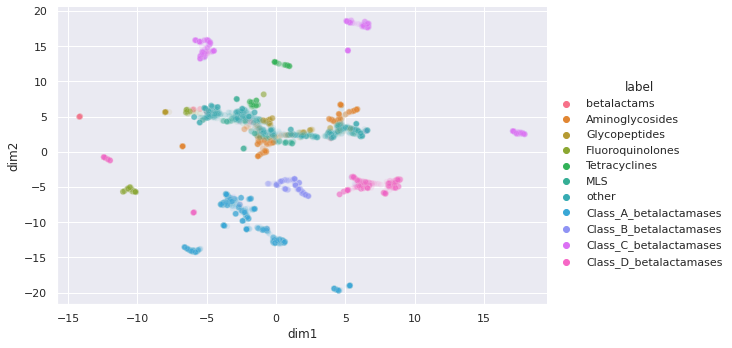

In [ ]:
reduced_embedding = pd.DataFrame(reduced_embedding, columns=['dim1', 'dim2'])
reduced_embedding["label"] = np.array(label_value)
sns.relplot(data=reduced_embedding, x="dim1", y='dim2',
                hue='label', hue_order=label_code_2.keys(), aspect=1.61, alpha = 0.1)
plt.show()

0.3516776817488561


(array([2.070e+02, 9.060e+02, 3.597e+03, 1.261e+03, 8.920e+02, 2.910e+02,
        2.010e+02, 1.240e+02, 6.600e+01, 9.300e+01, 3.200e+01, 1.270e+02,
        1.100e+01, 3.100e+01, 1.000e+00, 2.300e+01, 1.000e+00, 2.000e+00,
        0.000e+00, 2.000e+00]),
 array([ 121. ,  379.8,  638.6,  897.4, 1156.2, 1415. , 1673.8, 1932.6,
        2191.4, 2450.2, 2709. , 2967.8, 3226.6, 3485.4, 3744.2, 4003. ,
        4261.8, 4520.6, 4779.4, 5038.2, 5297. ]),
 <a list of 20 Patch objects>)

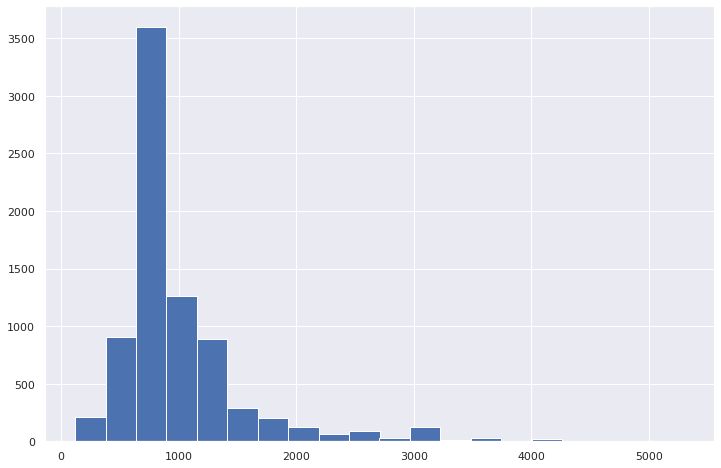

In [ ]:
seq_len = np.array([len(m) for m in df.Sequence.values])
print((seq_len>1000).mean())
plt.hist(seq_len, bins = 20)

In [ ]:

# Create dataloaders

In [ ]:
# Create model

In [ ]:
# Train model

In [ ]:
# Test model